<h1>Table of Contents &lt;br&gt;&lt;/br&gt;<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-and-Data-loading" data-toc-modified-id="Imports-and-Data-loading-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports and Data loading</a></span></li></ul></li><li><span><a href="#Real-data-comparison" data-toc-modified-id="Real-data-comparison-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Real data comparison</a></span><ul class="toc-item"><li><span><a href="#Plot-differences" data-toc-modified-id="Plot-differences-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plot differences</a></span></li></ul></li><li><span><a href="#Demand-Patterns" data-toc-modified-id="Demand-Patterns-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Demand Patterns</a></span><ul class="toc-item"><li><span><a href="#Yearly-rental-patterns" data-toc-modified-id="Yearly-rental-patterns-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Yearly rental patterns</a></span></li><li><span><a href="#Weekly-Pattern-of-connected-EVS" data-toc-modified-id="Weekly-Pattern-of-connected-EVS-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Weekly Pattern of connected EVS</a></span></li><li><span><a href="#Daily-Pattern-of-connected-EVS" data-toc-modified-id="Daily-Pattern-of-connected-EVS-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Daily Pattern of connected EVS</a></span></li><li><span><a href="#2.4.-Average-Daily-Pattern" data-toc-modified-id="2.4.-Average-Daily-Pattern-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>2.4. Average Daily Pattern</a></span></li></ul></li></ul></div>

## Imports and Data loading

In [1]:
# Display plots inline
%matplotlib inline

# Autoreload all package before excecuting a call
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from evsim.data import load_car2go_trips, load_car2go_capacity

In [3]:
df = pd.read_csv("../logs/stats.csv", parse_dates=[0], infer_datetime_format=True)
df = df.set_index("timestamp")
df.describe()

,fleet,fleet_soc,ev_vpp,vpp_soc,vpp_capacity_kw
count,19283.000000,19283.000000,19283.000000,19283.000000,19283.000000
mean,467.539439,72.871637,20.607582,67.832886,74.187295
std,28.952755,4.262076,10.305397,6.596531,37.099428
min,3.000000,57.160000,0.000000,0.000000,0.000000
25%,469.000000,70.000000,13.000000,63.260000,46.800000
50%,472.000000,73.150000,18.000000,67.310000,64.800000
75%,473.000000,76.020000,27.000000,72.090000,97.200000
max,495.000000,82.460000,65.000000,98.160000,234.000000


# Real data comparison

In [4]:
real_cap = load_car2go_capacity()
real_cap["timestamp"] = real_cap["timestamp"].apply(lambda x : datetime.fromtimestamp(x))
real_cap = real_cap.set_index("timestamp")
real_cap.describe()

,fleet,fleet_soc,rent,rent_soc,charging,charging_soc,vpp,vpp_soc,vpp_capacity_kw
count,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000
mean,467.540863,64.187231,370.482524,65.199535,86.101535,62.142629,85.896443,52.670121,309.227194
std,28.952680,3.272551,44.401928,2.222441,27.656815,2.973727,27.674290,3.903693,99.627443
min,3.000000,52.237020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,469.000000,62.069328,346.000000,63.790740,65.000000,60.320000,65.000000,50.128353,234.000000
50%,472.000000,64.557201,373.000000,65.404167,79.000000,62.000000,78.000000,52.421464,280.800000
75%,473.000000,66.696349,401.000000,66.739465,107.000000,64.039412,107.000000,55.066667,385.200000
max,495.000000,81.000000,495.000000,97.000000,178.000000,83.000000,178.000000,70.925373,640.800000


## Plot differences

Average SoC difference: 8.68


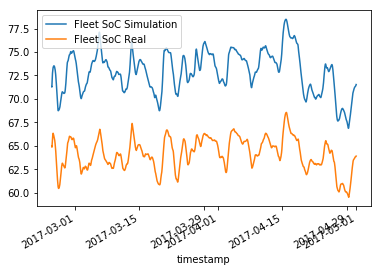

In [5]:
merge = df.merge(real_cap, left_index=True, right_index=True, how='left')
merge["fleet_soc_diff"] = merge["fleet_soc_x"] - merge["fleet_soc_y"]
print("Average SoC difference: %.2f" % merge.fleet_soc_diff.mean())

merge = merge.rolling(window=int(1 * 12 * 24)).mean()
ax = merge.plot(y='fleet_soc_x', label='Fleet SoC Simulation')
merge.plot(y='fleet_soc_y', label='Fleet SoC Real', ax=ax)
plt.show()

Average Capacity difference: -236.32kW


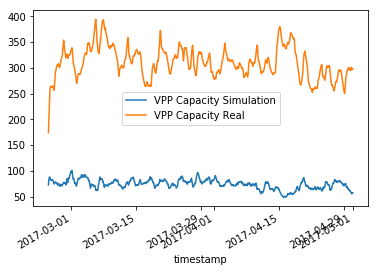

In [6]:
merge["fleet_cap"] = merge["vpp_capacity_kw_x"] - merge["vpp_capacity_kw_y"]
print("Average Capacity difference: %.2fkW" % merge.fleet_cap.mean())
ax = merge.plot(y='vpp_capacity_kw_x', label='VPP Capacity Simulation')
merge.plot(y='vpp_capacity_kw_y', label='VPP Capacity Real', ax=ax)
plt.show()

# Demand Patterns

In [7]:
def apply_smoother(df, days):
    DAY = 12*24

    df['vpp_avg'] = df['ev_vpp'].rolling(
        window=int(days*DAY)).mean()
    df['vpp_soc_avg'] = df['vpp_soc'].rolling(
        window=int(days*DAY)).mean()
    df['vpp_capacity_kw_avg'] = df['vpp_capacity_kw'].rolling(
        window=int(days*DAY)).mean()

    return df


def plot(df, title, start="2016-12-1", end="2017-04-28"):
    X = df.loc[start:end][['vpp_avg', 'vpp_soc_avg', 'vpp_capacity_kw_avg']]
    return X.plot(figsize=(12, 4), title=title)

## Yearly rental patterns

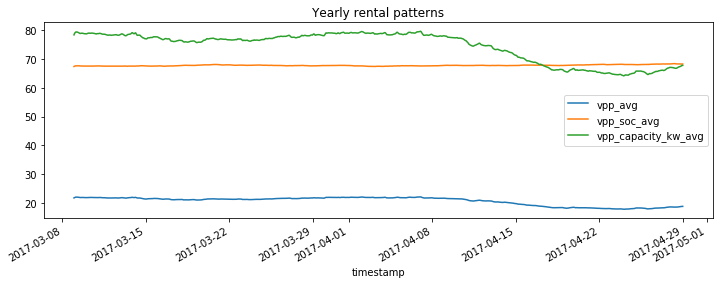

In [8]:
df = apply_smoother(df, days=14)
plot(df, "Yearly rental patterns");

## Weekly Pattern of connected EVS

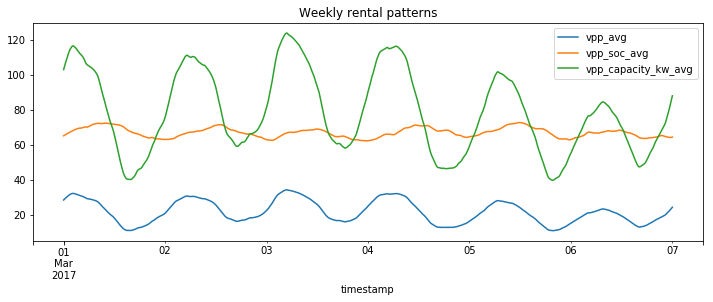

In [9]:
df = apply_smoother(df, days=0.5)
plot(df, "Weekly rental patterns", start=datetime(
    2017, 3, 1), end=datetime(2017, 3, 7));

## Daily Pattern of connected EVS

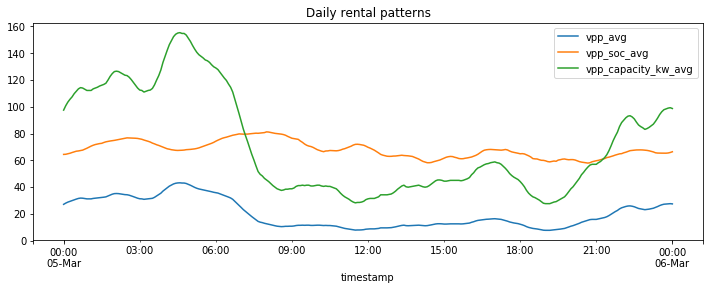

In [10]:
df = apply_smoother(df, days=1/24)
plot(df, "Daily rental patterns", start=datetime(
    2017, 3, 5), end=datetime(2017, 3, 6));

## 2.4. Average Daily Pattern

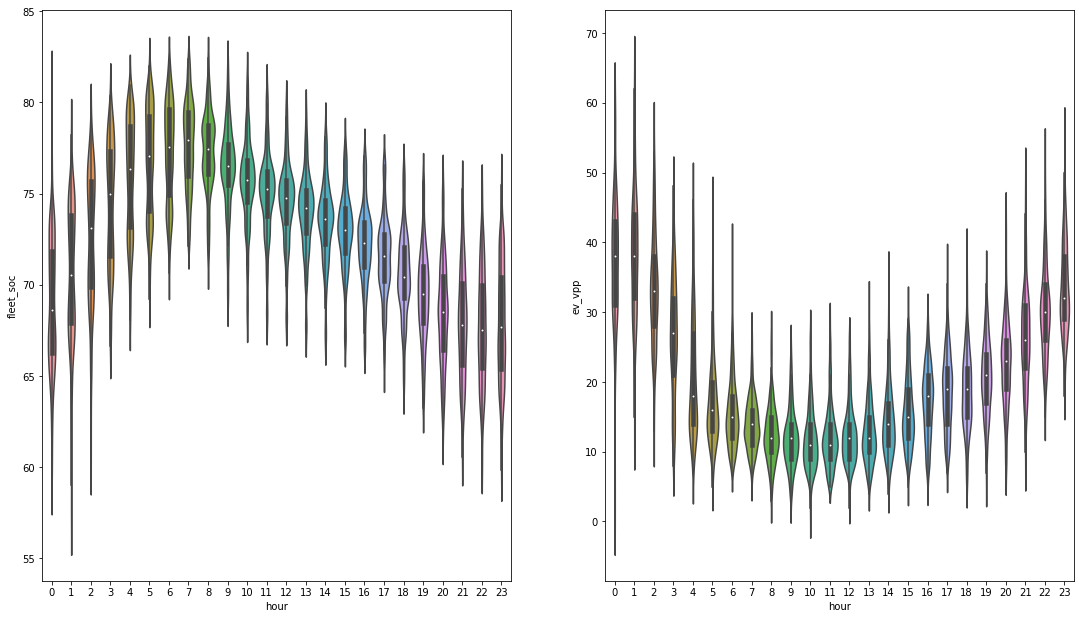

In [11]:
df["hour"] = df.index.hour

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(18.5, 10.5)
sns.violinplot(x="hour", y="fleet_soc", data=df, ax=ax1)
sns.violinplot(x="hour", y="ev_vpp", data=df, ax=ax2);